In [1]:
# ============================================================
# Analysis configuration
# Fast conversion, analysis, and plotting of point concentration
# wind tunnel measurements
# ============================================================

# Paths and filenames
path_dir="/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare" #base path
path=f"{path_dir}/Data/InputData/Beispiel Umrechnung zur Kontrolle/"               #raw input data
namelist=['UBA_GA_02_04_01_000_1_001']                                             #prefix from all raw input files to use, can be multiple
output_path=f"{path_dir}/Data/Results/"                                            
# Ambient/Parameter file                                                           #parameter file, if not found, default values used
csv_file=f"{path_dir}/Data/ParameterFiles/ambient_conditions_.UBA_GA.csv"
parameters_PerFolder=False                                                         #Use one parametercolumn for all files(True), separate for each file (False)

# Scaling and processing
# nd = non-dimensional, ms = model scale, fs = full scale, when outputted
full_scale='ms'

#Legacy, apply down-averaging post calculation
applyPostprocessing=True                                 #If True
averageInterval=60          # s
measurementFreq=0.005       # Hz
averagingColumns=["net_concentration"]

# Output and saving, Output: calculated ts per file,averages per file, statistic per file, combined avg and stats for all files in one csv
osType="Linux"
outputName=None
saveTs=True
saveAvg=True
saveStats=True
saveCombined=True
combinedFileName="combined_file_test.csv"
base_path=None
saveAll=True

"""
# Uncertainty analysis (Legacy)
calculateUncertainty=True
saveUncertainties=True
saveConfigNames=True
split_factor=1.8
uncertainty_threshold=1e-4
verboseUncertainty=True
uncertaintyMetrics=None
uncertaintyConcentrationTypes=None
includeAbsoluteUncertainty=True
includePercentageUncertainty=True
# Combined file options
columnsToSave=None
# Legacy uncertainty (for plotting)
uncertainty_value=None
uncertainty_representation="percentage"  # or "absoluteValue"
"""

'\n# Uncertainty analysis (Legacy)\ncalculateUncertainty=True\nsaveUncertainties=True\nsaveConfigNames=True\nsplit_factor=1.8\nuncertainty_threshold=1e-4\nverboseUncertainty=True\nuncertaintyMetrics=None\nuncertaintyConcentrationTypes=None\nincludeAbsoluteUncertainty=True\nincludePercentageUncertainty=True\n# Combined file options\ncolumnsToSave=None\n# Legacy uncertainty (for plotting)\nuncertainty_value=None\nuncertainty_representation="percentage"  # or "absoluteValue"\n'

In [2]:
#Example file/Default environment values if no csv_file found:

#Source location  [mm]
x_source=0
y_source=0
z_source=0
#Source mass flow controller, calibration settings
mass_flow_controller=0.300 #0.600#Stickstoffdurchflussregler #[l/h]*1/100 #'X'  #Controller(settings) used, just a name placeholder for orientation, not used yet
#If calibration performed on a controller, corrects actual max. flow capacity of controller
calibration_curve=1.0     #0.3     #0.3 oder 3
calibration_factor=0 #1      #
#Gas characteristics
gas_name='C12'           #Just placeholder name variable for orientation, not used for anything
gas_factor=0.5   #[-]    #!!! Needs to be calculate/specificate f.e. if gas changes 
mol_weight=29.0 #28.97 #Air [g/mol]
#Measurement location [mm]
x_measure=1020 #855.16
y_measure= 0    #176.29
z_measure= 5     #162
#Surrounding conditions
pressure=101426.04472        #1009.38  #[hPa] ->Pa
temperature=23             #23.5  #[°C]
#Model to Reality scaling
scale=400                     #250      #Model/Reality
scaling_factor=0.5614882               #0.637       #USA1 to selected ref pos.?
ref_length=1/400              #1/250           #Lref
ref_height=100/400            #None            #Href
#Full Scale Parameters
full_scale_wtref=10             #6         #Uref_fullscale
full_scale_flow_rate=0.002     #Q_amb[kg/s]?   #0.5   #Qv_fullscale
full_scale_temp=20             #[°C]
full_scale_pressure=101325     #[Pa]
#Q_ambient[kg/s] ->  Q[m³/s]=Q[kg/s]*R*T/(M*p)
#Variable wdir for wind direction. To be implemented in future. ##
#wdir=0
#Variable axis_range. Reserved for future implementation of axis range specification, 
#analogously to puff mode
#axis_range='auto'


In [ ]:
#Imports
import windtunnel as wt
import os
import sys
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

from windtunnel.concentration.CompareDatasets import *
from windtunnel.pipelines.concentration_point import run_point_concentration

# Reload utils module to get latest changes
if 'windtunnel.concentration.utils' in sys.modules:
    importlib.reload(sys.modules['windtunnel.concentration.utils'])

# Edited Nora: Check if ambient conditions file is even there, before trying out reading-in
print(f"CSV erwartet unter: {csv_file}")
if os.path.exists(csv_file):
    print("✅ CSV-Datei gefunden.")
else:
    print("❌ CSV-Datei NICHT gefunden.")
    print("Folgende Dateien sind im Ordner vorhanden:")
    for f in os.listdir(path):
        print(f)

# --- Compute (pipeline) ---
result = run_point_concentration(
    path=path,
    namelist=namelist,
    csv_file=csv_file,
    parameters_per_folder=parameters_PerFolder,
    full_scale=full_scale,
    save_all=saveAll,
    save_ts=saveTs,
    save_avg=saveAvg,
    save_stats=saveStats,
    save_combined=saveCombined,
    os_type=osType,
    output_path=output_path,
    combined_filename=combinedFileName,
)

conc_ts = result.conc_ts
files = result.files_by_name[namelist[0]]

# --- Optional: uncertainties (used for later extensions like combine_to_csv2) ---
uncertainty_results = {}
if calculateUncertainty and saveCombined:
    from windtunnel.concentration.utils import calculate_uncertainties

    if verboseUncertainty:
        metrics_str = ", ".join(uncertaintyMetrics) if uncertaintyMetrics else "all"
        conc_types_str = ", ".join(uncertaintyConcentrationTypes) if uncertaintyConcentrationTypes else "c_star only"
        print(f"\n📊 Calculating measurement uncertainties for: {metrics_str} ({conc_types_str})")

    for name in namelist:
        uncertainty_results.update(
            calculate_uncertainties(
                conc_ts[name],
                split_factor=split_factor,
                uncertainty_threshold=uncertainty_threshold,
                verbose=verboseUncertainty,
                metrics_to_calculate=uncertaintyMetrics,
                concentration_types=uncertaintyConcentrationTypes,
                include_abs=includeAbsoluteUncertainty,
                include_pct=includePercentageUncertainty,
            )
        )

# Mapping: Filename → config_name
mapping = {file: conc_ts[name][file].config_name for name in namelist for file in conc_ts[name]}


CSV erwartet unter: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/ParameterFiles/ambient_conditions_.UBA_GA.csv
✅ CSV-Datei gefunden.
files: ['UBA_GA_02_04_01_000_1_001.txt.ts#0', 'UBA_GA_02_04_01_000_1_001.txt.ts#1', 'UBA_GA_02_04_01_000_1_001.txt.ts#2', 'UBA_GA_02_04_01_000_1_001.txt.ts#3', 'UBA_GA_02_04_01_000_1_001.txt.ts#4', 'UBA_GA_02_04_01_000_1_001.txt.ts#5']
Store information into PointConcentration class objects array
Do main calculations
Transform scale


/home/sabrina/WindTunnelSoftware_V3010126/Manual/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.time = time
/home/sabrina/WindTunnelSoftware_V3010126/Manual/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:65: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.open_rate = open_rate
/home/sabrina/WindTunnelSoftware_V3010126/Manual/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.wtref = wtref
/home/sabrina/WindTunnelSoftware_V3010126/Manual/WTSoftwareUtilitie

Store information into PointConcentration class objects array
Do main calculations
Transform scale
Store information into PointConcentration class objects array
Do main calculations
Transform scale


/home/sabrina/WindTunnelSoftware_V3010126/Manual/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.time = time
/home/sabrina/WindTunnelSoftware_V3010126/Manual/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:65: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.open_rate = open_rate
/home/sabrina/WindTunnelSoftware_V3010126/Manual/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.wtref = wtref
/home/sabrina/WindTunnelSoftware_V3010126/Manual/WTSoftwareUtilitie

Store information into PointConcentration class objects array
Do main calculations
Transform scale
Store information into PointConcentration class objects array
Do main calculations
Transform scale


/home/sabrina/WindTunnelSoftware_V3010126/Manual/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.time = time
/home/sabrina/WindTunnelSoftware_V3010126/Manual/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:65: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.open_rate = open_rate
/home/sabrina/WindTunnelSoftware_V3010126/Manual/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.wtref = wtref
/home/sabrina/WindTunnelSoftware_V3010126/Manual/WTSoftwareUtilitie

Store information into PointConcentration class objects array
Do main calculations
Transform scale

📊 Calculating measurement uncertainties for: all (c_star only)
   test (c_star): File UBA_GA_02_04_01_000_1_001.txt.ts#0 (len=30000) normal processing
   test (c_star): File UBA_GA_02_04_01_000_1_001.txt.ts#1 (len=30000) normal processing
   test (c_star): File UBA_GA_02_04_01_000_1_001.txt.ts#2 (len=30000) normal processing
   test (c_star): File UBA_GA_02_04_01_000_1_001.txt.ts#3 (len=30000) normal processing
   test (c_star): File UBA_GA_02_04_01_000_1_001.txt.ts#4 (len=30000) normal processing
   test (c_star): File UBA_GA_02_04_01_000_1_001.txt.ts#5 (len=30000) normal processing
✅ Configuration test (c_star): 6 files -> 6 samples (splits: 0)
Created ts files including (net_concentration, entimendionsliased and full scale concentration)
Created avg files under /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_avg/UBA_GA_02_04

In [4]:
#Uncertainty calculation is now integrated in Cell 2 and modularized in utils.calculate_uncertainties()
#This cell is no longer needed - uncertainty calculation happens automatically before saveCombined
np.mean(conc_ts[name][file].c_star)
#0.0013838297350440441 für 0.3
#0.0006919148675220221 für 0.3

0.0006919148675220221


 File: UBA_GA_02_04_01_000_1_001.txt.ts#0
c_star vorhanden
C_star shape: (30000,)
NaNs vorhanden: False
Min/Max: -0.30316299999999985 / 1202.017763
Mean: 57.80034634370001
Std: 57.766640161132536
Percentiles: {10: 12.215996500000001, 90: 120.00919130000001, 95: 161.68999759999997}

 File: UBA_GA_02_04_01_000_1_001.txt.ts#1
c_star vorhanden
C_star shape: (30000,)
NaNs vorhanden: False
Min/Max: -1.1505290000000001 / 779.15148
Mean: 57.68628691473333
Std: 61.95945048114293
Percentiles: {10: 9.1554916, 90: 125.9157658000001, 95: 173.63429904999998}

 File: UBA_GA_02_04_01_000_1_001.txt.ts#2
c_star vorhanden
C_star shape: (30000,)
NaNs vorhanden: False
Min/Max: -0.621735 / 795.289011
Mean: 52.02871467456667
Std: 57.61027356225919
Percentiles: {10: 7.128442400000001, 90: 116.657799, 95: 158.66340479999997}

 File: UBA_GA_02_04_01_000_1_001.txt.ts#3
c_star vorhanden
C_star shape: (30000,)
NaNs vorhanden: False
Min/Max: -0.8273609999999999 / 814.549495
Mean: 47.412503647
Std: 51.9680188034305

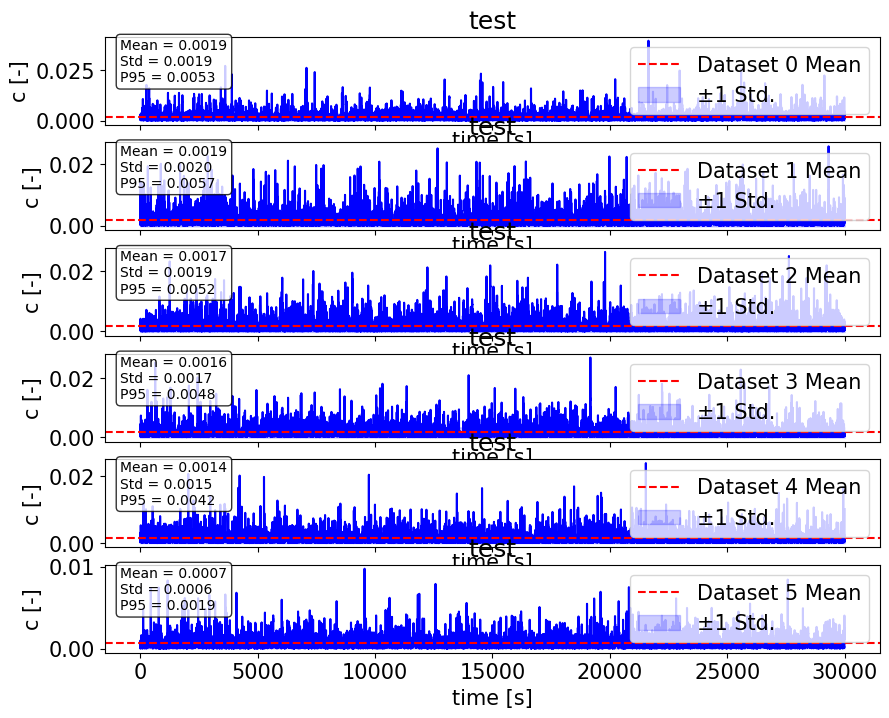

In [5]:
#Test numerical value range
for name in namelist:
    for file in files:
        print(f"\n File: {file}")
        if hasattr(conc_ts[name][file], "c_star"):
            print("c_star vorhanden")
        else:
            print("Keine c_star Daten gefunden.")

        print("C_star shape:", conc_ts[name][file].net_concentration.shape)
        #print(conc_ts[name][file].net_concentration)
        #plt.plot(conc_ts[namelist[0]][files[0]].c_star)
        print("NaNs vorhanden:", np.any(np.isnan(conc_ts[name][file].net_concentration)))
        print("Min/Max:", np.min(conc_ts[name][file].net_concentration), "/", np.max(conc_ts[name][file].net_concentration))
        print(f"Mean: {np.mean(conc_ts[name][file].net_concentration)}")
        print(f"Std: {np.std(conc_ts[name][file].net_concentration)}")
        print(f"Percentiles: {conc_ts[name][file].calc_percentiles(percentiles=[10, 90, 95], var='net_concentration')}")    
plt.show()
#plt.violinplot([conc_ts[name][file].c_star for file in files])
#plt.show()

#Read-in Data into separat array for later plotting (files/series can also be specifically choosen)
dimensionless=True
color="blue"

DataPointsConc = []
#DataPointsConc = [ conc_ts[namelist[0]]["MyFileofInterest1.txt"], conc_ts[namelist[0]]["MyFileofInterest2.txt"]]
for i in range(len(files)): #Just visualising all
    data = conc_ts[namelist[0]][files[i]]
    DataPointsConc.append(data)
# Richtige Zeitserien laden
labels=[f"Dataset {i}" for i in range(0,len(DataPointsConc))]
plot_timeseries_with_stats(DataPointsConc,dimensionless=dimensionless,labels=labels,color=color)

[191.1711425166667, 46.59676312166666, 14.19278708866667, 7.925406690666662, 0.021087820083330655]
[129.70314641666664, 31.181590431666663, 10.847684875000006, 6.899539998166674, 1.772200359583323]
[141.5670969333333, 32.77503943666666, 9.870075067333325, 4.920635326166661, 0.9165446198333385]
[110.15718923333336, 27.162796098333324, 7.330642992333345, 5.694779225000005, 3.859295252999999]
[79.68427418333333, 21.704997195000004, 7.134927745333329, 4.667101114333327, 2.873633315083339]
[76.71157831666667, 19.92285522166666, 7.927559724666658, 4.380431845333327, 0.9446214741666665]


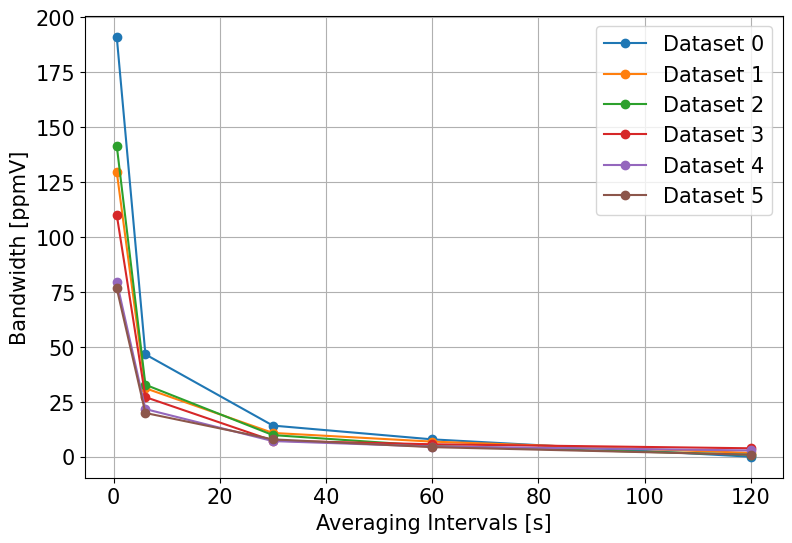

In [7]:
#Bandwidth convergence plot
xLabel = "Time Interval"
yLabel = "Windspeed [m/s]"
Labels = None
dimensionless = True #False
xAchse = None
yAchse = None
error_values = 0.1
marker = 'o'
#colors = ["green",""blue"]
time_freq = 0.010 #s
averaging_intervals = [60*0.01,60*0.1,60*0.5,60*1.0,60*2.0]# [60*0.01,60*0.1,60*0.5, 60*1,60*2,60*3,60*4,60*5]#in s     #Example for [15,30 and 60 min]
#t*[[-] =[s/(m/s) * m]  = t[s] / Uref[m/s] * Lref[m]
#TODO:Bandwidth=True

bandwidths = []
for name in namelist:
    for file in files:
        ts_v_avg = conc_ts[name][file].get_averagedData(name, file, time_freq, averaging_intervals)
        bandwidths.append([np.max(avg) - np.min(avg) for avg in ts_v_avg])  # or use np.ptp(avg)(peakTopeak) for same result, but faster
for i, bandwidth in enumerate(bandwidths):
    print(bandwidth)
    plt.plot(averaging_intervals, bandwidth, "o-", 
             label=f"Dataset {i}" if Labels is None else Labels[i])
plt.xlabel("Averaging Intervals [s]")
plt.ylabel("Bandwidth [ppmV]")
plt.legend()
plt.grid(True)
plt.show()

Dataset 0: [0.006313029842040534, 0.004088470850472941, 0.0033742264677527577, 0.002574988540657962, 0.0020765899687581477, 0.0014659990022119565, 0.0015387613018211124, 0.0012078549683998115, 0.0008675832598240597, 0.0007487953788206873, 0.0007874751290426589, 0.000458823668864874, 0.0004797049403861564, 0.00039986345857349805, 0.0003185637251192778, 0.0002778069486133695, 0.0002915135295233015, 0.00024021989967789974, 0.0002617200916928369, 0.0002119290143829985, 7.515753585020553e-05, 7.787937784328779e-05, 0.00010561794223415042, 2.006259542802237e-05, 6.963814503438675e-07]
Dataset 1: [0.00428526432366627, 0.0031948640576944104, 0.0026655418757167795, 0.0021797054420755104, 0.00149613823831543, 0.0015262204261530445, 0.0010302090637241822, 0.0007727472987452075, 0.0007328387936329686, 0.0006191178829370687, 0.000417182394214192, 0.00038290146141953577, 0.00035783704870248753, 0.00031209422297488764, 0.0004067561384117845, 0.00026938585789396726, 0.000232066993921655, 0.00017889954

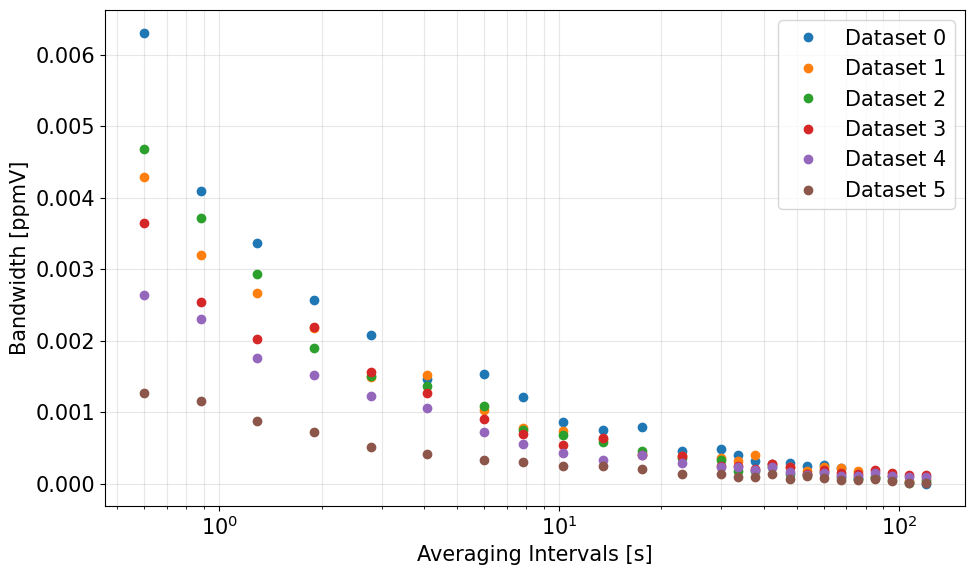

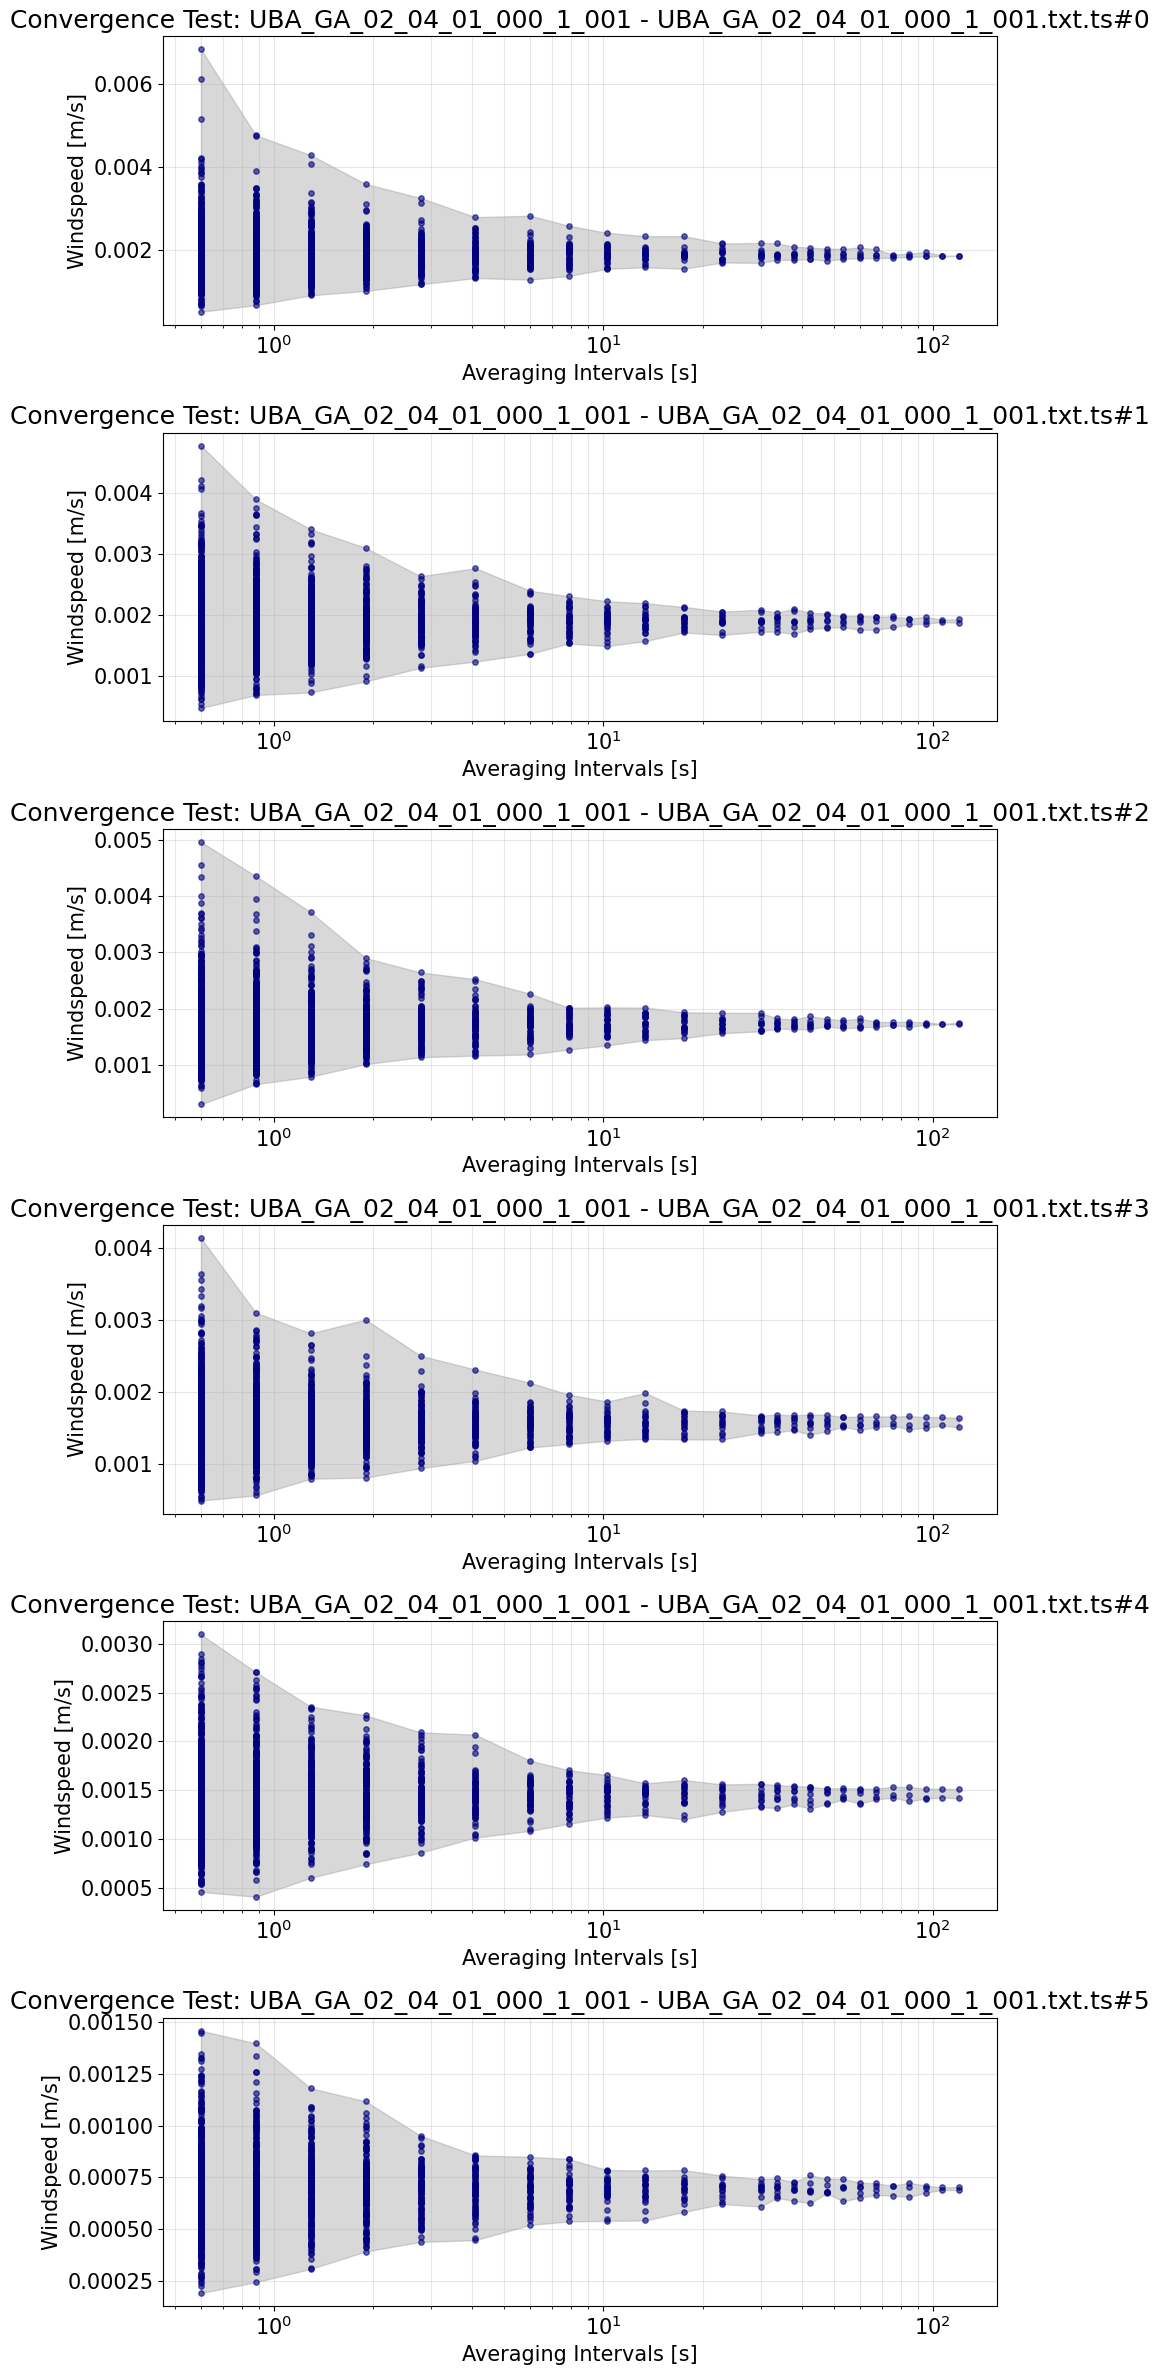

In [8]:
#Plot Convergence plot at different averaging intervals
# SCATTER CONVERGENCE PLOT (plot_type="convergence") (Scatter plot of all means at each averaging interval)
# BANDWIDTH CONVERGENCE PLOT (plot_type="bandwidth") (Max - Min of all means at each averaging interval)

# Configuration
plot_type = "both" #"bandwidth"  # Options: "bandwidth", "convergence", "both"
averaging_intervals = [60*0.01, 60*0.1, 60*0.5, 60*1.0, 60*2.0]  # in seconds
time_freq = 0.010  # s #Manually implace frequence between each measurement point, if dynamic write time_freq= dynamic
num_points_between = 5  # Number of points to add between each interval pair for more continuity(0 = use original intervals only)
set_xlog = True  #Set x-axsis to log

xLabel = "Time Interval"
yLabel = "Windspeed [m/s]"
Labels = None
dimensionless = True
xAchse = None
yAchse = None
error_values = 0.1
marker = 'o'

#For generate extended intervals/points if requested
if num_points_between > 0:
    extended_intervals = []
    for i in range(len(averaging_intervals) - 1):
        start = averaging_intervals[i]
        end = averaging_intervals[i + 1]
        points = np.logspace(np.log10(start), np.log10(end), num_points_between + 2)
        extended_intervals.extend(points[:-1])
    extended_intervals.append(averaging_intervals[-1])
    averaging_intervals_use = extended_intervals
else:
    averaging_intervals_use = averaging_intervals


# BANDWIDTH CONVERGENCE PLOT 
if plot_type in ["bandwidth", "both"]:
    bandwidths = []
    for name in namelist:
        for file in files:
            ts_v_avg = conc_ts[name][file].get_averagedData(name, file, time_freq, averaging_intervals_use,dimensionless)
            bandwidths.append([np.ptp(avg) for avg in ts_v_avg])
    
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    for i, bandwidth in enumerate(bandwidths):
        print(f"Dataset {i}: {bandwidth}")
        ax1.plot(averaging_intervals_use, bandwidth, "o", 
                 label=f"Dataset {i}" if Labels is None else Labels[i])
    
    ax1.set_xlabel("Averaging Intervals [s]")
    ax1.set_ylabel("Bandwidth [ppmV]")
    ax1.set_xscale('log')
    ax1.legend()
    ax1.grid(True, which='both', alpha=0.3)
    plt.tight_layout()
    plt.show()

# INTERVAL CONVERGENCE PLOT
if plot_type in ["convergence", "both"]:
    means_all = []
    dataset_labels = []
    for name in namelist:
        for file in files:
            ts_v_avg = conc_ts[name][file].get_averagedData(name, file, time_freq, averaging_intervals_use,dimensionless)
            means_all.append(ts_v_avg)
            dataset_labels.append(f"{name} - {file}")
    n_datasets = len(means_all) 
    fig2, axes = plt.subplots(n_datasets, 1, figsize=(10, 4*n_datasets), sharex=False)
    if n_datasets == 1: # Handle single dataset case
        axes = [axes]
    for i, (means, ax, label) in enumerate(zip(means_all, axes, dataset_labels)):
        # Collect min and max values for each interval for grey background coloring
        min_vals = []
        max_vals = []
        intervals_with_data = []
        for interval, avg_data in zip(averaging_intervals_use, means):
            if len(avg_data) > 0:
                min_vals.append(np.min(avg_data))
                max_vals.append(np.max(avg_data))
                intervals_with_data.append(interval)
        if len(intervals_with_data) > 0: #Also plot connected shaded region
            ax.fill_between(intervals_with_data, min_vals, max_vals, 
                           color='grey', alpha=0.3, zorder=1)
        #Satter points on top
        for interval, avg_data in zip(averaging_intervals_use, means):
            ax.scatter(np.ones(len(avg_data)) * interval,
                      avg_data, 
                      s=15, c="navy", marker='o', alpha=0.6, zorder=2)
        ax.set_ylabel(yLabel)
        ax.set_xlabel("Averaging Intervals [s]")
        ax.set_title(f'Convergence Test: {label}')
        ax.grid(True, which='both', alpha=0.3)
        if set_xlog:
            ax.set_xscale('log')
    plt.tight_layout()
    plt.show()

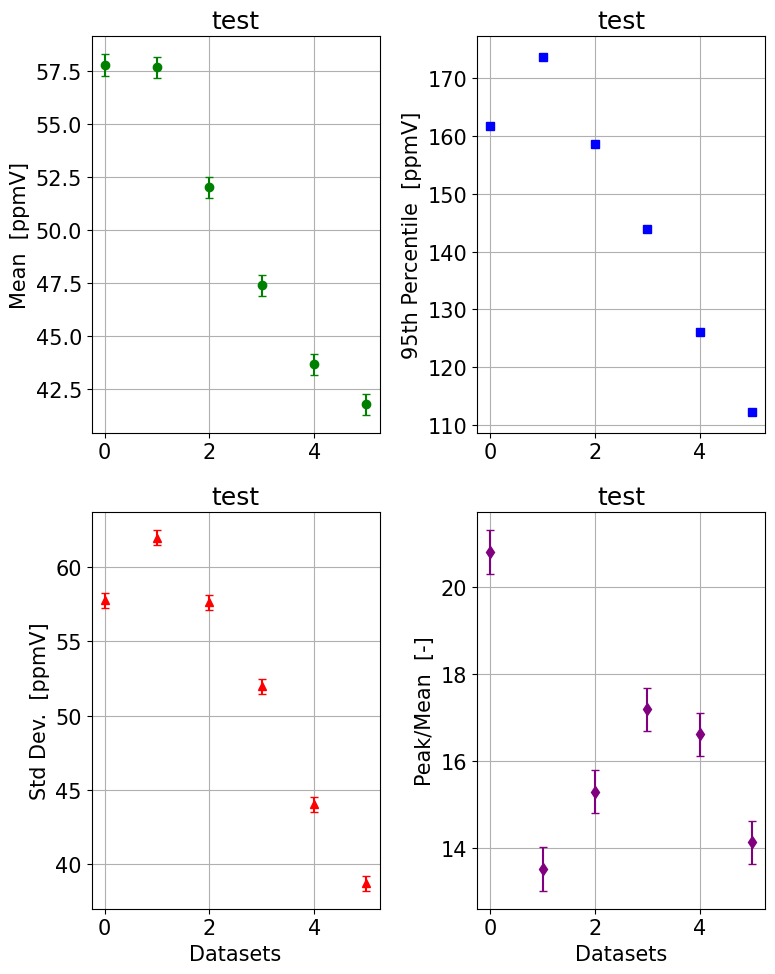

In [10]:
#4x1 Table means, std., peak2mean,percentile 
xLabels = "Datasets"
yLabels = ['Mean  [ppmV]', '95th Percentile  [ppmV]', 'Std Dev.  [ppmV]','Peak/Mean  [-]'] #None #"Concentration"
Labels = None
dimensionless = False
xAchse = None
yAchse = None
markers = ['o', 's', '^', 'd']
colors = ["green","blue","red","purple"]

error_values = 0.5 #[error_mean,error_95,error_std,error_peak/mean]
percentileValue = 95 #percentil for percentilCalculation 95->95%

# Calculate stats
x = range(len(DataPointsConc))
DataPointsConc2 = [DataPoints.net_concentration for DataPoints in DataPointsConc]
stats = [[np.mean(d),  np.percentile(d, percentileValue), np.std(d),np.max(d)/np.mean(d)] for d in DataPointsConc2]
stats = list(zip(*stats))
errors = error_values if isinstance(error_values, list) else [error_values] * len(DataPointsConc)

fig, axes = plt.subplots(2, 2, figsize=(8, 10))
axes_flat = axes.flatten()  # Convert 2x2 array to 1D array

for i, ax in enumerate(axes_flat):
    ax.errorbar(x, stats[i], yerr=errors, fmt=markers[i], capsize=3, color=colors[i])
    if yAchse: 
        ax.set_ylim(yAchse)
    if xAchse: 
        ax.set_xlim(xAchse)
    if i >= 2:  # Bottom row subplots
        ax.set_xlabel(xLabels)
    ax.set_ylabel(yLabels[i])
    ax.grid(True)   
    ax.set_title(data.config_name)
    # ax.set_xticks(x)
    # ax.set_xticklabels([f'Dataset {j+1}' for j in x])

plt.tight_layout()
if Labels != None:
    plt.legend(Labels)
plt.show()

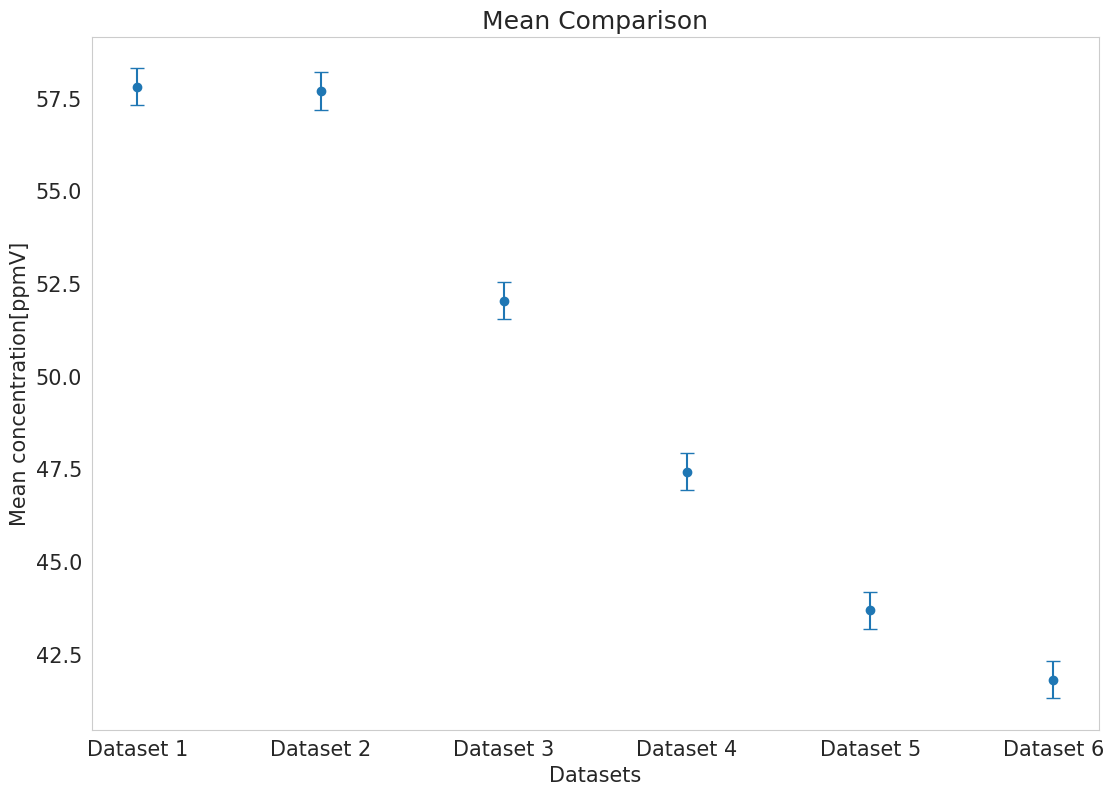

In [11]:
xLabel="Datasets"
yLabel="Mean concentration[ppmV]" 
dimensionless="False"
xAchse = None 
yAchse=None #(72,79) #None 
error_values=0.5 #[0.5,0.2,0.1] #For error values overgive one number which is cast to all values, or an array if specify different errors for each measurements
errorType="absolute"
test = create_means(DataPointsConc,error_values,dimensionless=dimensionless,labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=xAchse,yAchse=yAchse)
#plt.savefig("Mean_comparison.png",test) #To save image

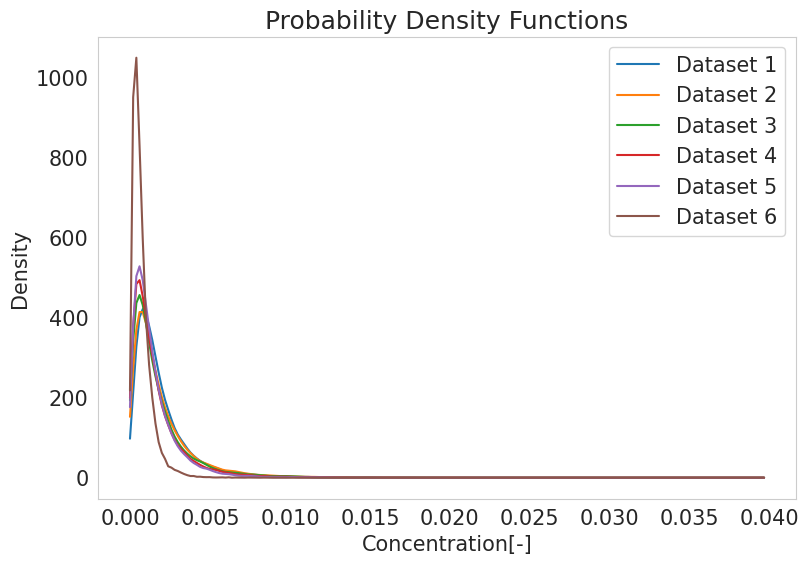

In [12]:
xLabel="Concentration[-]"
yLabel="Density"
dimensionless="True"
create_pdf(DataPointsConc,dimensionless="True",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

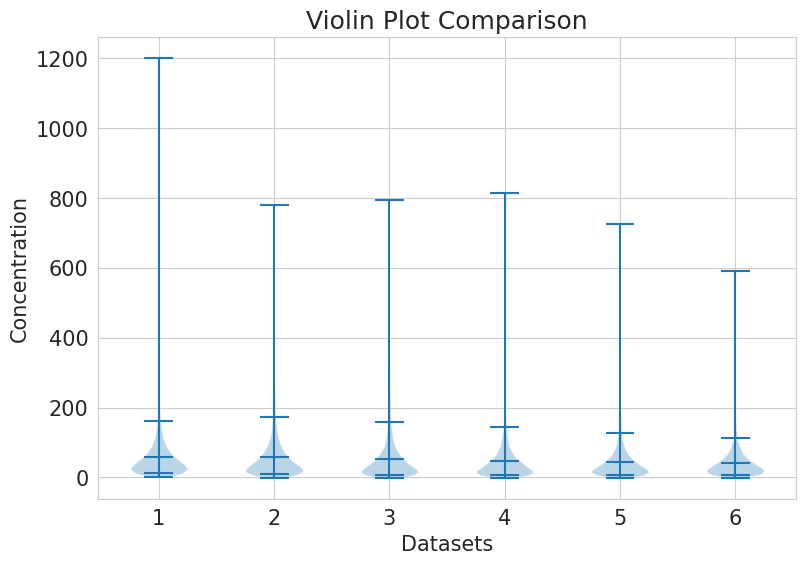

In [13]:
xLabel="Datasets"
yLabel="Concentration [-]"
dimensionless="True"
create_violinplot(DataPointsConc)

AttributeError: module 'matplotlib.pyplot' has no attribute 'get_xticklabels'

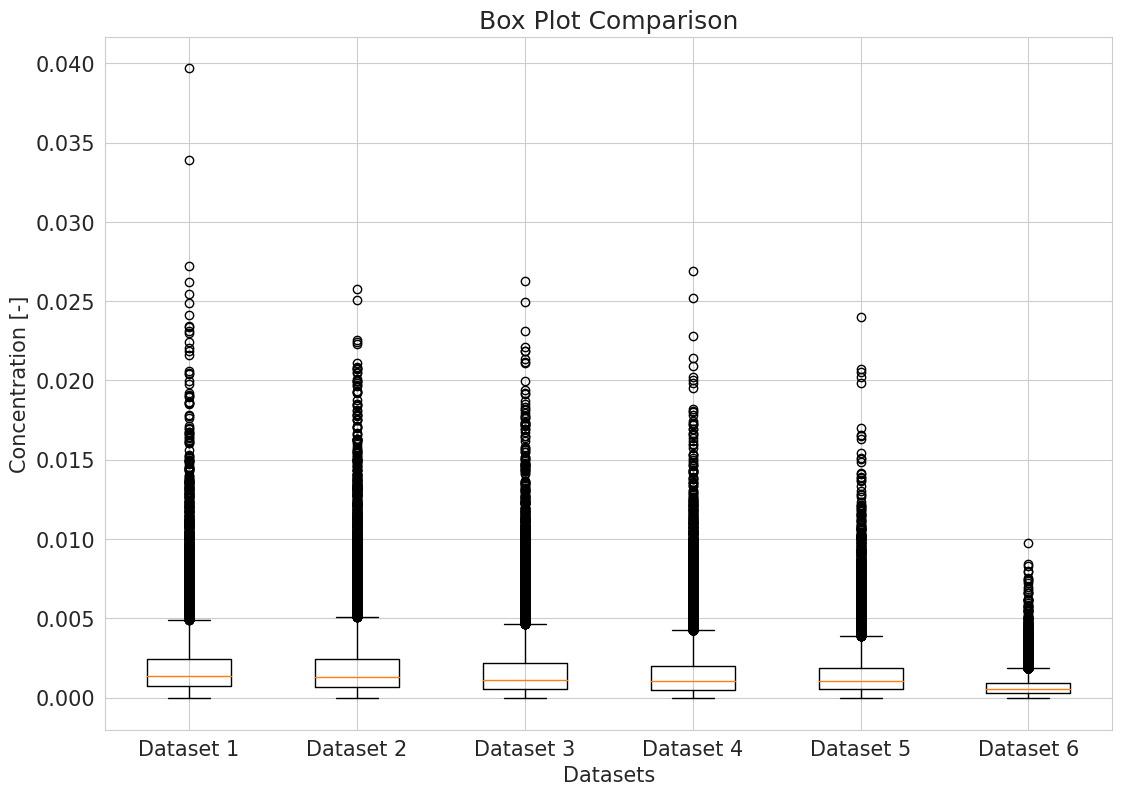

In [14]:
xLabel="Datasets"
yLabel="Concentration [-]"
dimensionless="True"
create_boxplot(DataPointsConc,dimensionless="True",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

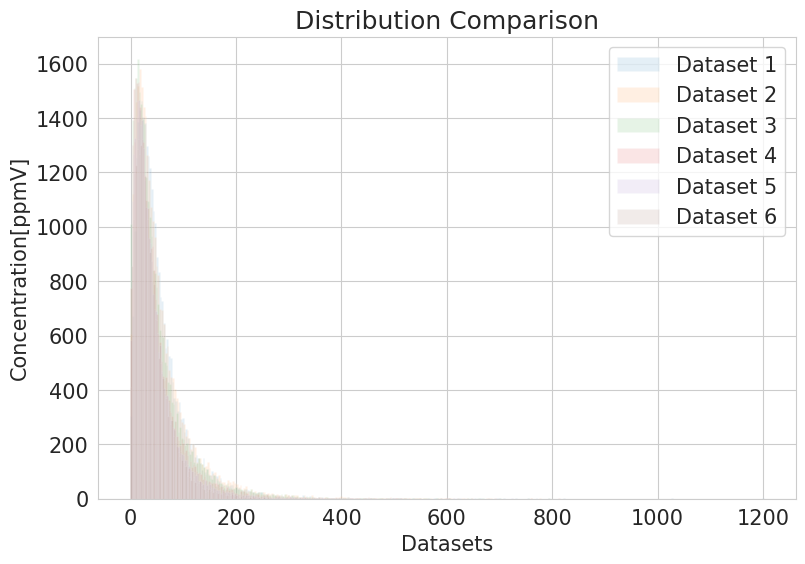

In [15]:
xLabel="Datasets"
yLabel="Concentration[ppmV]"
xLabel="Datasets"
yLabel="Concentration[ppmV]"
create_histogram(DataPointsConc,dimensionless="False",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

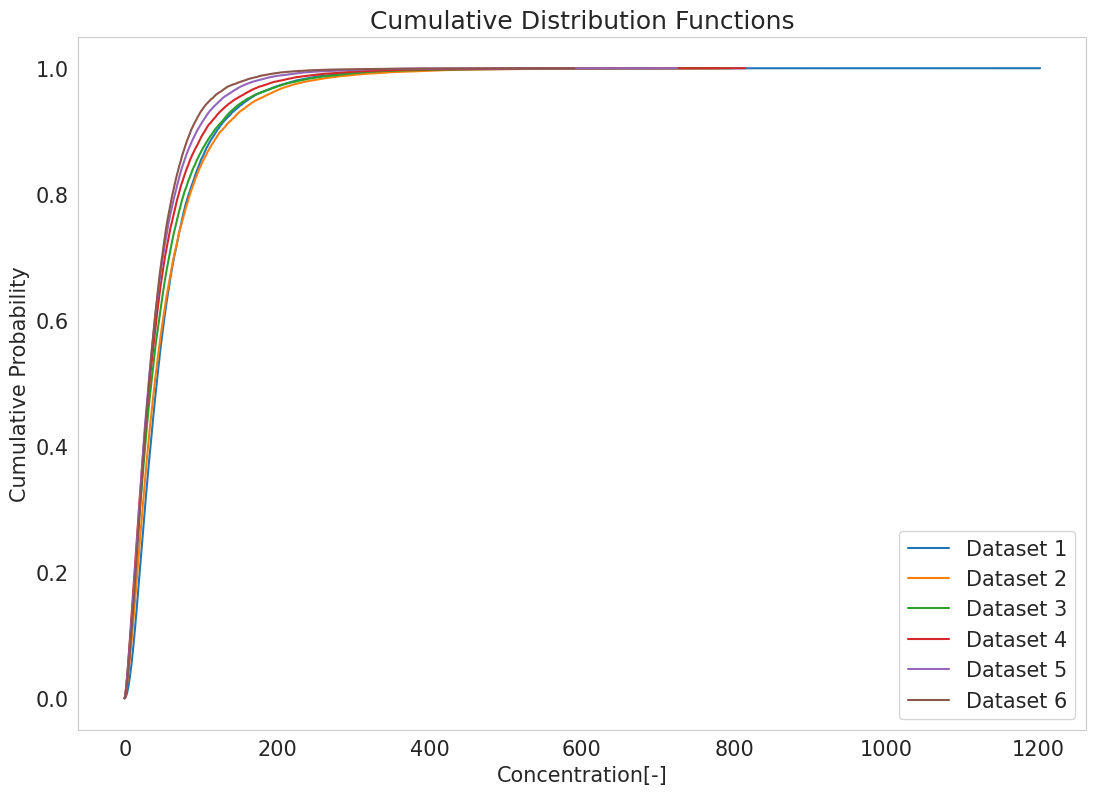

In [16]:
yLabel=None
xLabel="Concentration[-]"
dimensionless="False"
create_cdf(DataPointsConc,dimensionless=dimensionless,labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

[array([ 0.      ,  0.390625,  0.78125 ,  1.171875,  1.5625  ,  1.953125,
        2.34375 ,  2.734375,  3.125   ,  3.515625,  3.90625 ,  4.296875,
        4.6875  ,  5.078125,  5.46875 ,  5.859375,  6.25    ,  6.640625,
        7.03125 ,  7.421875,  7.8125  ,  8.203125,  8.59375 ,  8.984375,
        9.375   ,  9.765625, 10.15625 , 10.546875, 10.9375  , 11.328125,
       11.71875 , 12.109375, 12.5     , 12.890625, 13.28125 , 13.671875,
       14.0625  , 14.453125, 14.84375 , 15.234375, 15.625   , 16.015625,
       16.40625 , 16.796875, 17.1875  , 17.578125, 17.96875 , 18.359375,
       18.75    , 19.140625, 19.53125 , 19.921875, 20.3125  , 20.703125,
       21.09375 , 21.484375, 21.875   , 22.265625, 22.65625 , 23.046875,
       23.4375  , 23.828125, 24.21875 , 24.609375, 25.      , 25.390625,
       25.78125 , 26.171875, 26.5625  , 26.953125, 27.34375 , 27.734375,
       28.125   , 28.515625, 28.90625 , 29.296875, 29.6875  , 30.078125,
       30.46875 , 30.859375, 31.25    , 31.640625,

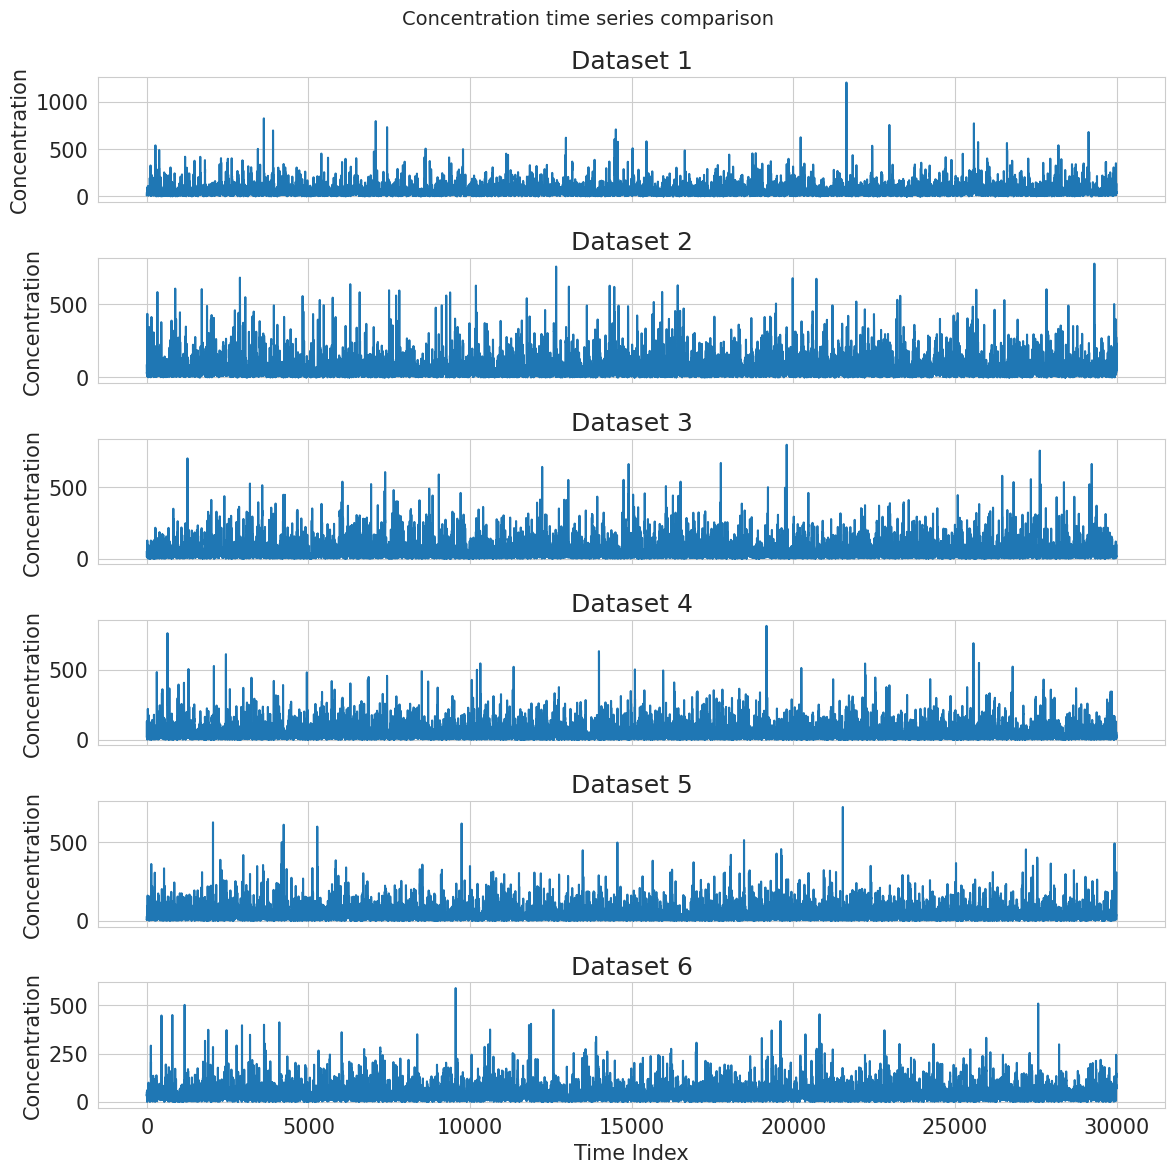

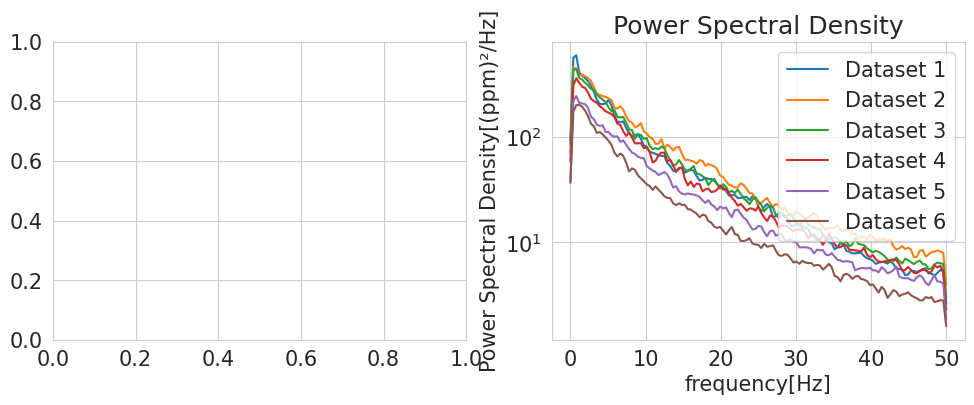

TypeError: Figure.savefig() takes 2 positional arguments but 3 were given

<Figure size 900x600 with 0 Axes>

In [17]:
test = powerDensityPlot(DataPointsConc,dimensionless="False",plot=True,labels=None,xLabel=None,yLabel=None,xAchse=None,yAchse=None)
plt.savefig("test.png",test)

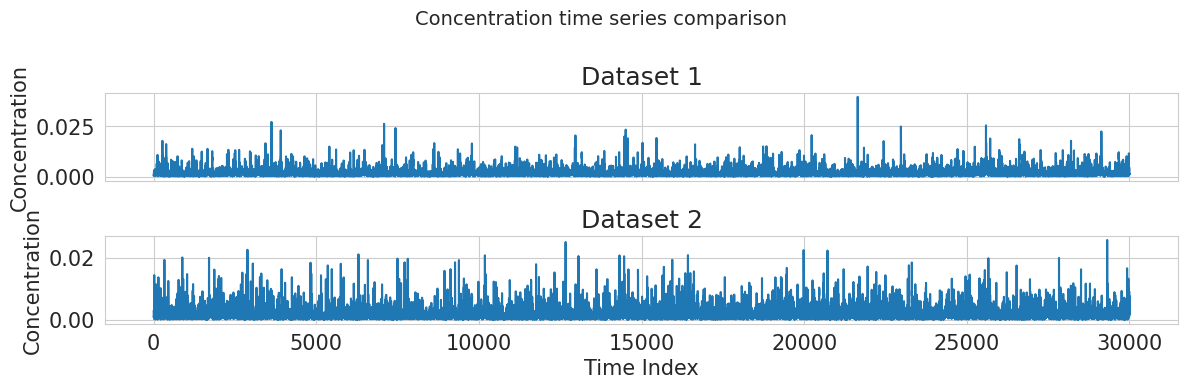

matplotlib.legend: WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1 2]
2
3
[array([ 0.      ,  0.390625,  0.78125 ,  1.171875,  1.5625  ,  1.953125,
        2.34375 ,  2.734375,  3.125   ,  3.515625,  3.90625 ,  4.296875,
        4.6875  ,  5.078125,  5.46875 ,  5.859375,  6.25    ,  6.640625,
        7.03125 ,  7.421875,  7.8125  ,  8.203125,  8.59375 ,  8.984375,
        9.375   ,  9.765625, 10.15625 , 10.546875, 10.9375  , 11.328125,
       11.71875 , 12.109375, 12.5     , 12.890625, 13.28125 , 13.671875,
       14.0625  , 14.453125, 14.84375 , 15.234375, 15.625   , 16.015625,
       16.40625 , 16.796875, 17.1875  , 17.578125, 17.96875 , 18.359375,
       18.75    , 19.140625, 19.53125 , 19.921875, 20.3125  , 20.703125,
       21.09375 , 21.484375, 21.875   , 22.265625, 22.65625 , 23.046875,
       23.4375  , 23.828125, 24.21875 , 24.609375, 25.      , 25.390625,
       25.78125 , 26.171875, 26.5625  , 26.953125, 27.34375 , 27.734375,
       28.125   , 28.515625, 28.90625 , 29.296875, 29.6875  , 30.078125,
       30.46875 , 30.859375, 31.25    , 

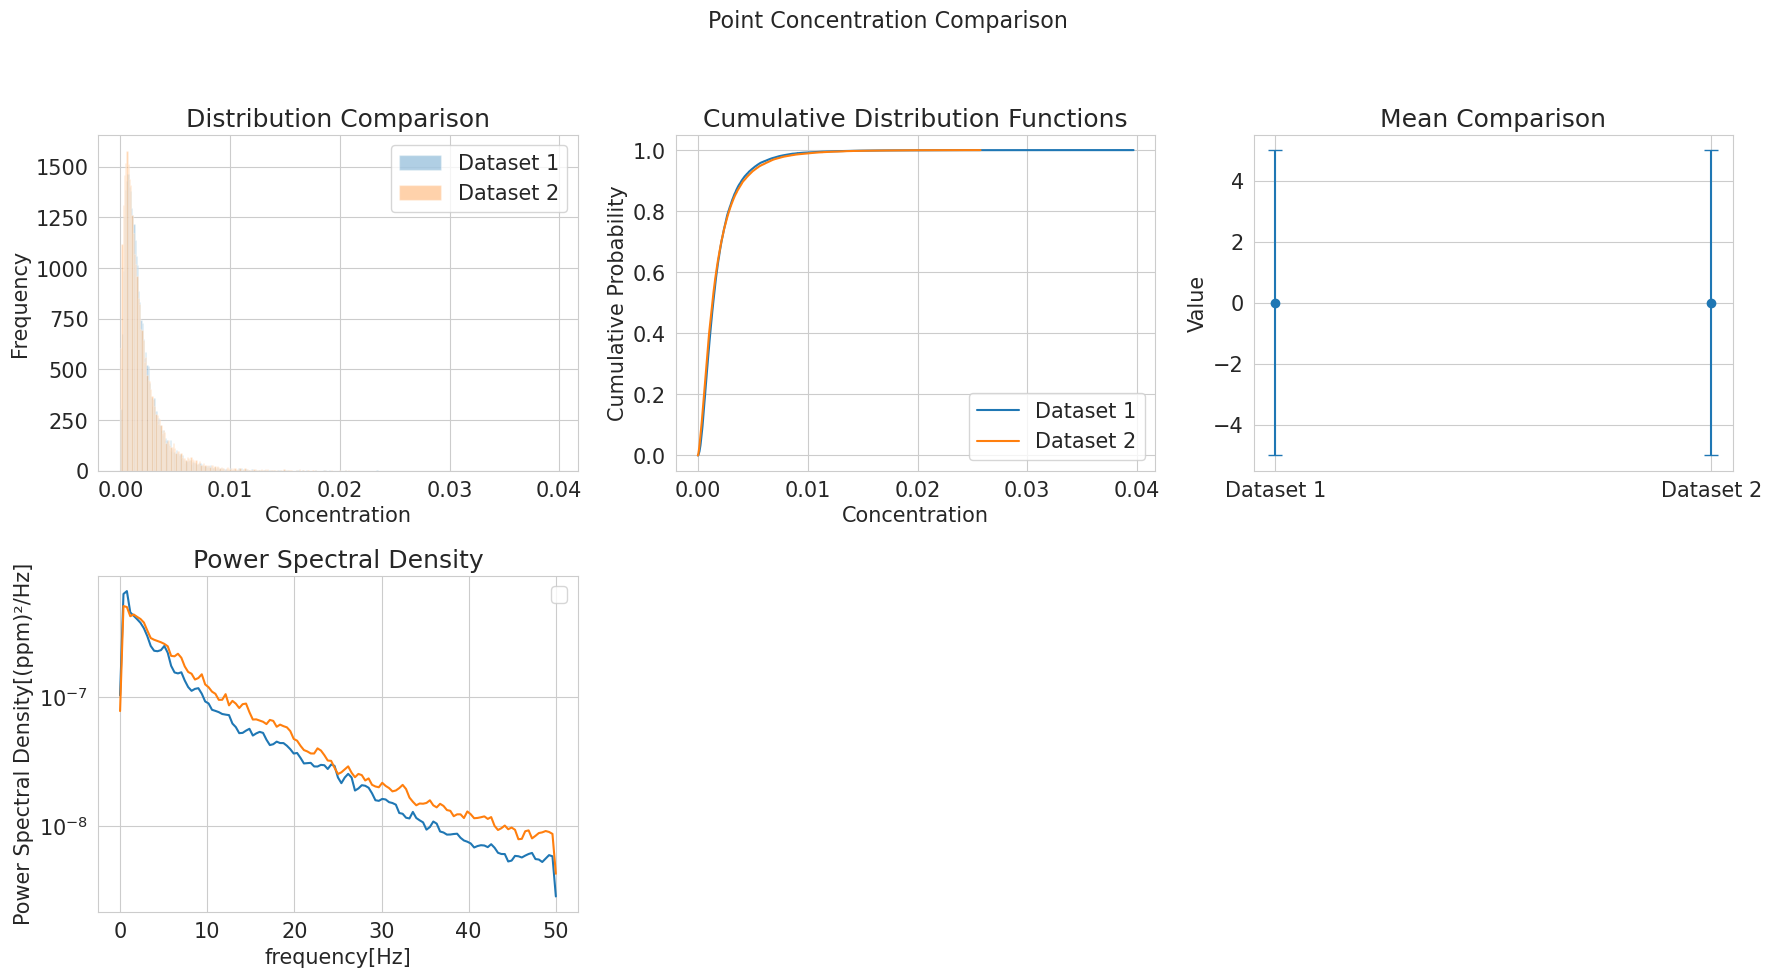


Detailed Comparison:
Mean: Dataset 1 = 0.0019, Dataset 2 = 0.0019
Std Dev: Dataset 1 = 0.0019, Dataset 2 = 0.0020
Skewness: Dataset 1 = 3.5959, Dataset 2 = 3.0479
Percentile 95: Dataset 1 = 0.0053, Dataset 2 = 0.0057
Turbulence Intensity v: Dataset 1 = 0.0081, Dataset 2 = 0.0080
Turbulence Intensity c: Dataset 1 = 0.9994, Dataset 2 = 1.0741
Pearson r (vs Dataset 1): Dataset 1 = N/A, Dataset 2 = 0.0110
Spearman rho (vs Dataset 1): Dataset 1 = N/A, Dataset 2 = -0.0011
RMSE (vs Dataset 1): Dataset 1 = N/A, Dataset 2 = 0.0028


In [18]:
from windtunnel.concentration.CompareDatasets import compare_point_concentrations_3
#Give overview/comparison for the data, one plot including of of the plots choosen in the list "functionsForOverview
#Means, Pdf, Cdf, PowerDensity: Number of ts does not matter that much
#Scatterplot: use only 2 ts
#Histogram, Boxplot: would also recommend not to many, because of overlapping of the histograms for comparison, space for the boxplots..

#functionsForOverview = ["all"] #defaul -> all of the available plots
#all_plot_types = [
#        "Histogram", "Pdf", "Cdf", "Means", "BoxPlot", 
#        "QuantilPlot", "ScatterPlot", "ResidualPlot", "Autocorrelation"
#    ]
    
functionsForOverview = [
    "Histogram",
    "BoxPlot"
    #"",
    "Pdf",
    "Cdf",
    "Means",
    "PowerDensity"
        ]

#Choose which concentration time series/PointObjekts to show in the overview/comparison plot
DataPointsConc = [
    conc_ts[namelist[0]][files[0]],#
    conc_ts[namelist[0]][files[1]],
    #conc_ts[namelist[0]][files[2]],
    #conc_ts[namelist[0]][files[3]],
    #conc_ts[namelist[0]][files[4]],
    #conc_ts[namelist[0]][files[5]]
]

compare_point_concentrations_3(DataPointsConc,functionsForOverview)

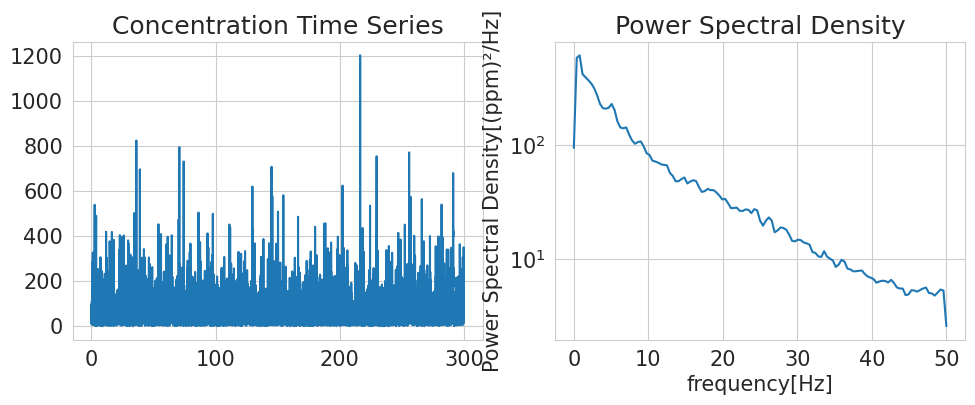

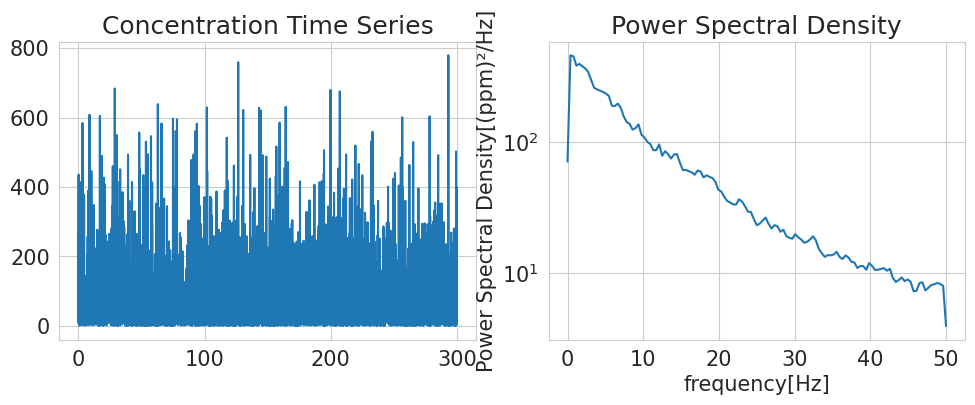

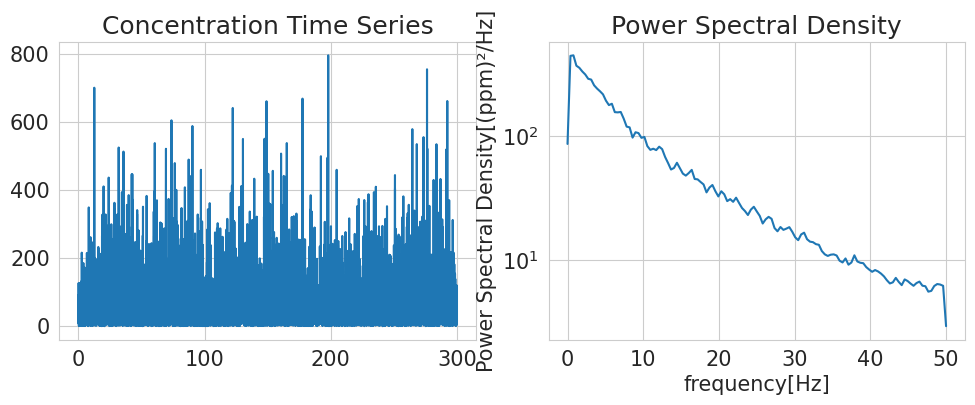

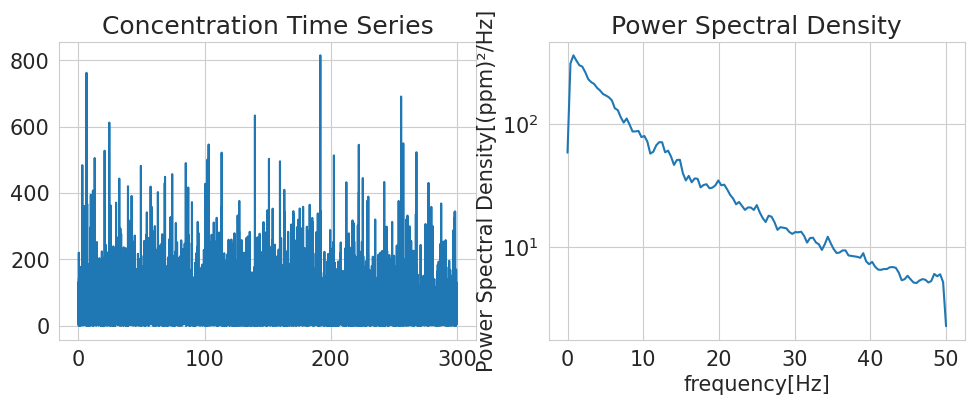

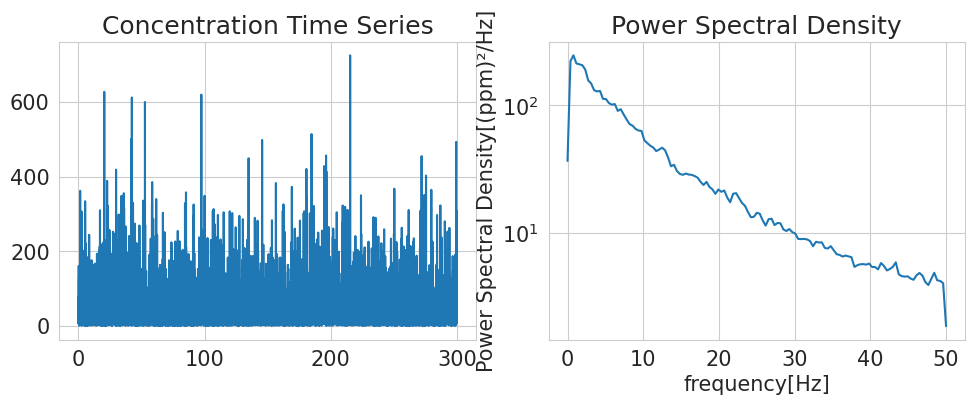

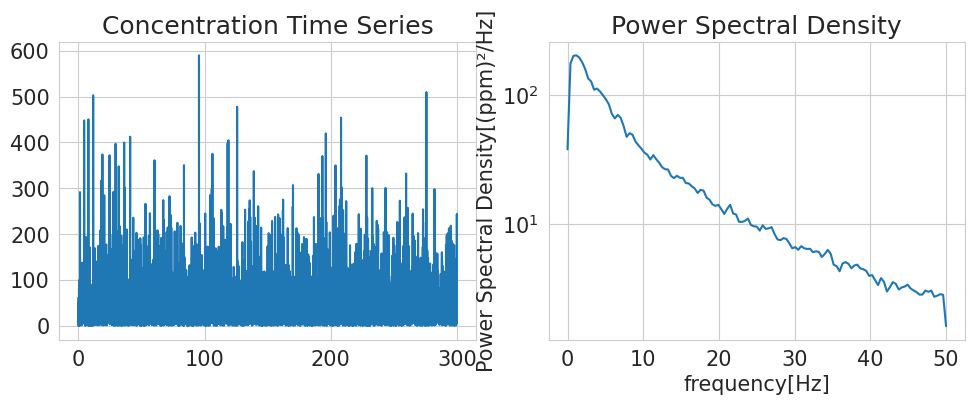

In [19]:
#Concentration fluctuation analysis 
#Intermittency based on threshold, peak2Mean, concentration variance spectral density distribution

#Seettings intermittency calculation
threshold_type="ratio" #ratio, absolute
threshold_method="mean" #mean, std
intermittency_threshold=1.5 #-> if type=ratio,method mean, threshold=threshold*mean(concentration), if type=absolute: threshold=threshold

for name in namelist:
    for file in files:
        conc_ts[name][file].analyze_concentration_fluctuations(dimensionless="False",
                                                       intermittency_threshold=intermittency_threshold,threshold_method=threshold_method)
#power(variance) of concentration changes for different frequencies/timer interval lengths 
#Low-frequency peak: Slow, gradual concentration changes
#High-frequency peak: Rapid, quick concentration fluctuations
#Broad spectrum: Mixed or complex concentration dynamics

In [ ]:
#For completeness also calculate further characteristic metrics of flow/ wind velocity time series (from wtref ts), skewness ..
#print(conc_ts[name][file].calculate_turbulence_intensity(dimensionless="True",returnDistribution="False",returnMetrics="True"))

In [ ]:
##Hier kommt deine für dein Expierment und Daten angepasste Fehlerberrechnung
